In [1]:
import matplotlib.pyplot as plt
import numpy as np


import mne
from mne.datasets.sleep_physionet.age import fetch_data

In [2]:
psg_file = "data/SC4001E0-PSG.edf"
psg_data = mne.io.read_raw_edf(psg_file)

Extracting EDF parameters from c:\Tum\5-AR-local\AprendizajeAutomatico\final\data\SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


In [3]:
fs = psg_data.info.get('sfreq')
print(fs,'Hz')

data = psg_data.get_data()
data.shape

100.0 Hz


(7, 7950000)

In [14]:
secs = data.shape[1]/fs
print(f'{secs} segundos')
print(f'{secs/60} minutos')
print(f'{secs/60/60} horas')


print(psg_data.ch_names)
print(psg_data.get_channel_types())
print(len(psg_data['EEG Fpz-Cz'][0][0]))

79500.0 segundos
1325.0 minutos
22.083333333333332 horas
['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']
['eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg', 'eeg']
7950000


In [18]:
len(psg_data['EEG Fpz-Cz'][0][0])
t = psg_data['EEG Fpz-Cz'][1]
t

array([0.000000e+00, 1.000000e-02, 2.000000e-02, ..., 7.949997e+04,
       7.949998e+04, 7.949999e+04])

In [9]:
print(psg_data.info.get('ch_names'))
EEG_Fpz_Cz, EEG_Pz_Oz, EOG_Horizontal, Resp_oro_nasal, EMG_submental, Temp_rectal, Event_marker= data[0], data[1], data[2], data[3], data[4], data[5], data[6]

['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']


In [44]:
hypnogramm_file = "data/SC4001EC-Hypnogram.edf"
hypnogramm_data = mne.io.read_raw_edf(hypnogramm_file)

print(hypnogramm_data.get_channel_types())


Extracting EDF parameters from c:\Tum\5-AR-local\AprendizajeAutomatico\final\data\SC4001EC-Hypnogram.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


C:\Users\flo12\AppData\Local\Temp\ipykernel_25124\27932481.py:2: RuntimeWarning: Header information is incorrect for record length. Default record length set to 1.
It is possible that this file only contains annotations and no signals. In that case, please use mne.read_annotations() to load these annotations.
  hypnogramm_data = mne.io.read_raw_edf(hypnogramm_file)
C:\Users\flo12\AppData\Local\Temp\ipykernel_25124\27932481.py:2: RuntimeWarning: Omitted 153 annotation(s) that were outside data range.
  hypnogramm_data = mne.io.read_raw_edf(hypnogramm_file)
C:\Users\flo12\AppData\Local\Temp\ipykernel_25124\27932481.py:2: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  hypnogramm_data = mne.io.read_raw_edf(hypnogramm_file)


ValueError: picks (NoneNone, treated as "all") yielded no channels, consider passing picks explicitly

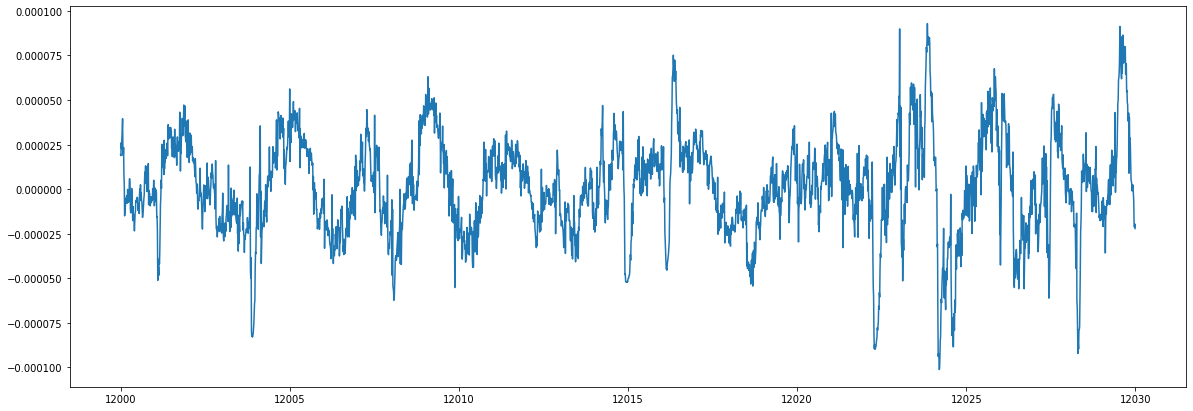

In [31]:
epoch = 400
plt.figure(figsize=(20,7))
plt.plot(t[int(epoch*30*fs):int((epoch + 1)*30*fs)],EEG_Fpz_Cz[int(epoch*30*fs):int((epoch + 1)*30*fs)])
plt.show()